# Latent Dirichlet Allocation models on BBC data

### Model 1. Scikit-learn

In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import textwrap
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import PorterStemmer
import spacy
import gensim
import gensim.corpora as corpora
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pickle
import pyLDAvis
import os
from gensim.models import CoherenceModel, TfidfModel
import pyLDAvis.gensim
import re


stops = stopwords.words('english')
stops.extend(['has', 'been', 're', 'com', 'edu', 'use', 'said', 'would', 'could', 'told', 'also', 'one', 'two', 'mr', 'new', 'year'])

In [2]:
# Read the data
df = pd.read_csv('bbc_text_cls.csv')

# Remove missing values
df.dropna(axis = 0, how ='any', inplace=True)

# Add num words column
df['Num_words_text'] = df['text'].apply(lambda x:len(str(x).split()))
max_review_data_sentence_length  = df['Num_words_text'].max()

# # Create a mask to filter out long reviews and very short ones
# mask = (df['Num_words_text'] < 100) & (df['Num_words_text'] >=20)
# df = df[mask]

# Remove punctuation
def remove_punctuation(text):
  return text.translate(str.maketrans('', '', string.punctuation))

df['text'] = df['text'].apply(remove_punctuation)

# Remove \n characters
df['text'] = df['text'].str.replace('\n', ' ')

# Remove digits and non-alphanumeric characters
df['text'] = df['text'].str.replace('[^a-zA-Z0-9\s]', '')

# Lowercase the text
df['text'] = df['text'].str.lower()

# Normalize whitespace
def normalize_whitespace(text):
    text = re.sub('[\s]+', ' ', text)
    return text

df['text'] = df['text'].map(normalize_whitespace)

# Remove stopwords
def remove_stopwords(text):
    text = " ".join([word for word in text.split() if word not in stops])
    return text

df['text'] = df['text'].apply(remove_stopwords)

# Lemmatization
def lemmatization(text, allowed_postags = ['NOUN', 'ADJ']):
  doc = nlp(''.join(text))
  doc = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
  return ' '.join(doc)

nlp = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])
df['text'] = df['text'].map(lemmatization)

# Stemming
def stemming(text):
  doc = [PorterStemmer().stem(w).strip() for w in text.split()]
  return ' '.join(doc)

df['text'] = df['text'].map(stemming)

# Remove words that contain digits
pattern = re.compile(r'\b\w*\d\w*\b')
df['text'] = df['text'].apply(lambda x: pattern.sub('', x))

# Normalize whitespace again
df['text'] = df['text'].map(normalize_whitespace)

<>:25: DeprecationWarning: invalid escape sequence \s
<>:32: DeprecationWarning: invalid escape sequence \s
<>:25: DeprecationWarning: invalid escape sequence \s
<>:32: DeprecationWarning: invalid escape sequence \s
C:\Users\User\AppData\Local\Temp\ipykernel_14204\1970057778.py:25: DeprecationWarning: invalid escape sequence \s
  df['text'] = df['text'].str.replace('[^a-zA-Z0-9\s]', '')
C:\Users\User\AppData\Local\Temp\ipykernel_14204\1970057778.py:32: DeprecationWarning: invalid escape sequence \s
  text = re.sub('[\s]+', ' ', text)
C:\Users\User\AppData\Local\Temp\ipykernel_14204\1970057778.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('[^a-zA-Z0-9\s]', '')


In [36]:
df['labels'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: labels, dtype: int64

In [4]:
# Create count vectorizer
vectorizer = CountVectorizer(stop_words = list(stops),
                            # min_df = 20,
                            # max_df = 0.2,
                            # max_features = 5000,
                            # ngram_range = (1,3)
                            )
X = vectorizer.fit_transform(df['text'])

# Create an LDA model
lda = LatentDirichletAllocation(n_components = 5, random_state = 12345, max_iter = 50)
lda.fit(X)

LatentDirichletAllocation(max_iter=50, n_components=5, random_state=12345)

In [5]:
# Auxillary plotting function
def plot_top_words(model, feature_names, n_top_words = 10):
  fig, axes = plt.subplots(2, 5, figsize = (30, 15), sharex = True)
  axes = axes.flatten()
  for topic_idx, topic in enumerate(model.components_):
    top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
    top_features = [feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]
    
    ax = axes[topic_idx]
    ax.barh(top_features, weights, height = 0.7)
    ax.set_title(f'Topic {topic_idx + 1}', fontdict = {'fontsize': 30})
    ax.invert_yaxis()
    ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
    for i in 'top right left'.split():
      ax.spines[i].set_visible(False)
    fig.suptitle("LDA", fontsize = 40)
  
  plt.subplots_adjust(top = 0.90, bottom = 0.05, wspace = 0.90, hspace = 0.3)
  plt.show()

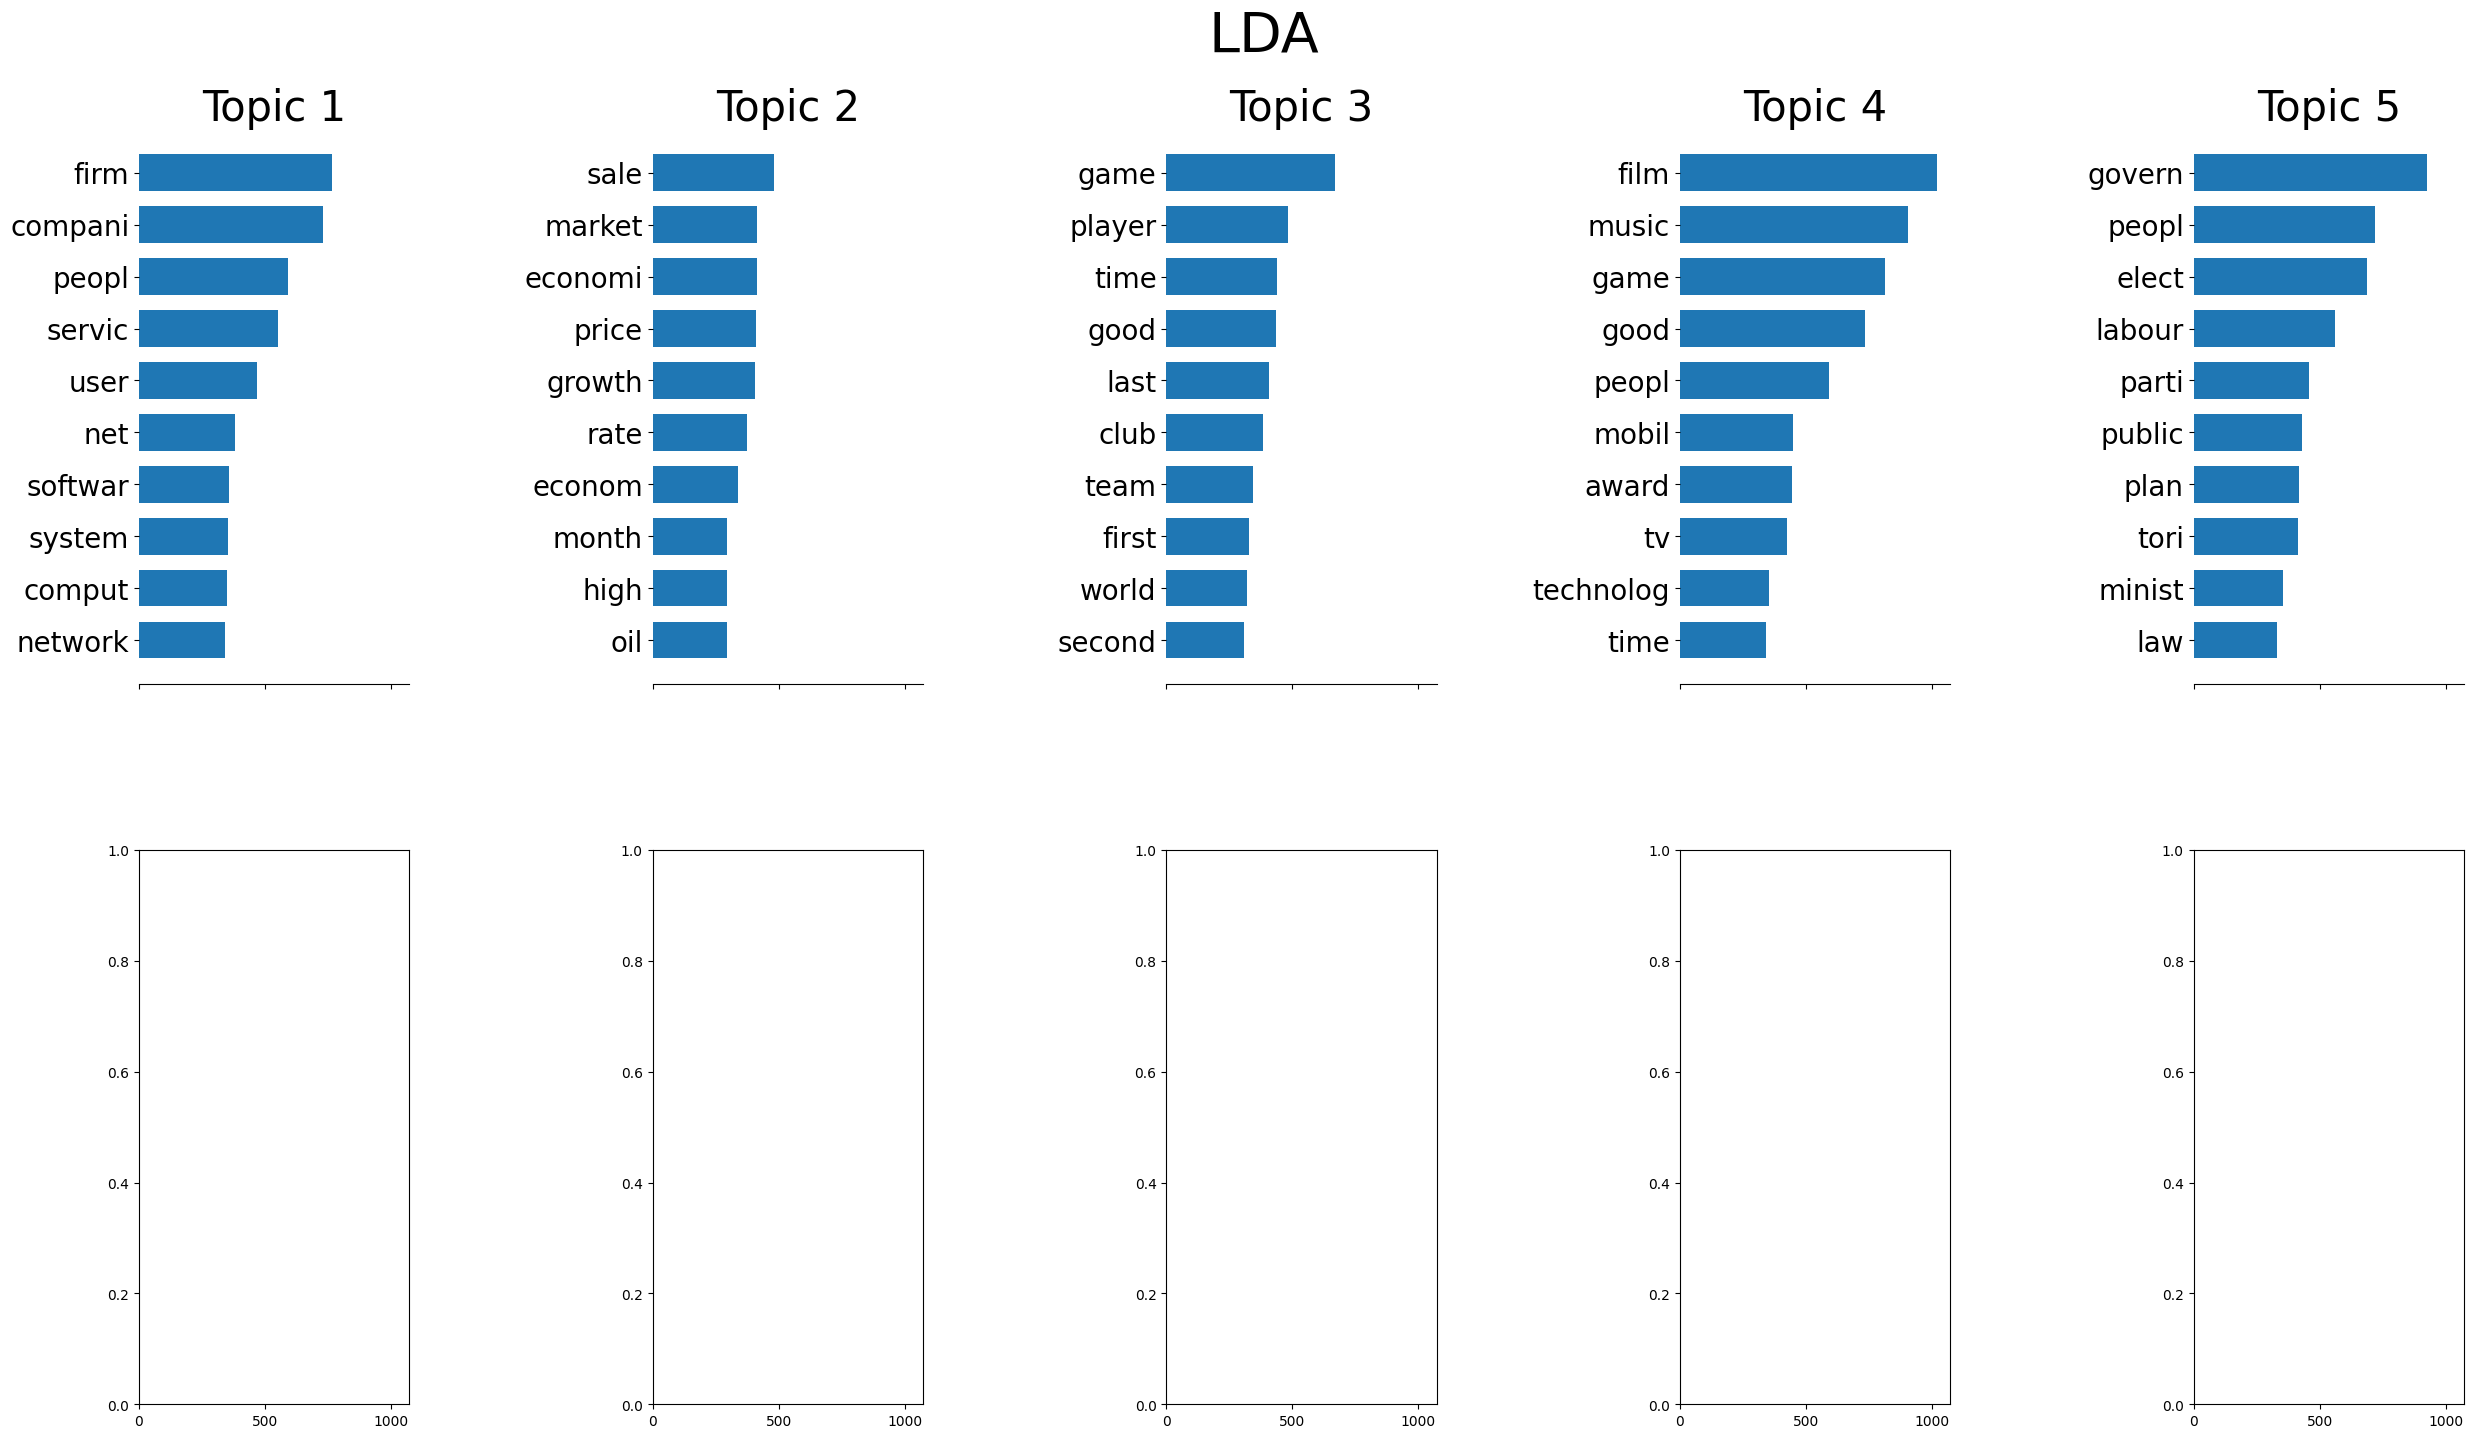

In [6]:
# Words per topics
feature_names = vectorizer.get_feature_names_out()
plot_top_words(lda, feature_names)

In [7]:
# Latent variables extraction
Z = lda.transform(X)

Text(0.5, 1.0, 'True label: sport')

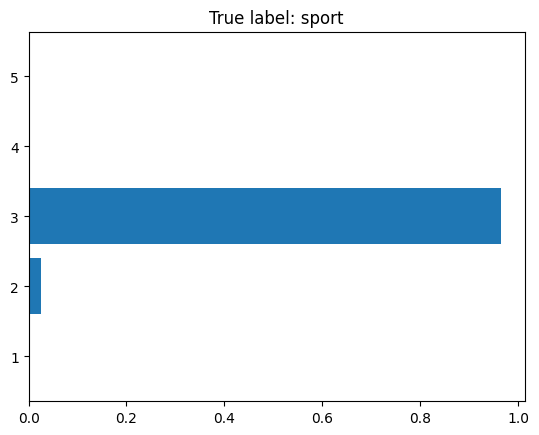

In [8]:
# Sample topic
np.random.seed(0)

i = np.random.choice(len(df))
z = Z[i]
topics = np.arange(5) + 1

fig, ax = plt.subplots()
ax.barh(topics, z)
ax.set_yticks(topics)
ax.set_title('True label: %s' % df.iloc[i]['labels'])

In [9]:
# # Associated article
# def wrap(x):
#   return textwrap.fill(x, replace_whitespace = False, fix_sentence_endings = True)

# print(wrap(df.iloc[i]['text']))

Text(0.5, 1.0, 'True label: entertainment')

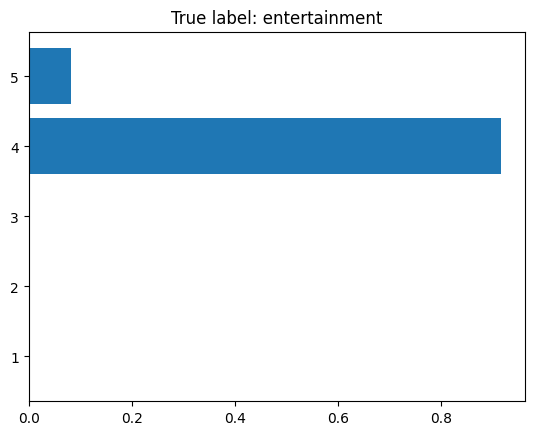

In [10]:
# Sample topic n2
i = np.random.choice(len(df))
z = Z[i]

fig, ax = plt.subplots()
ax.barh(topics, z)
ax.set_yticks(topics)
ax.set_title('True label: %s' % df.iloc[i]['labels'])

In [11]:
# # Associated article n2
# print(wrap(df.iloc[i]['text']))

### Model 2. Gensim

In [12]:
# Create document-term matrix
def create_document_term_matrix(dataframe, column_name):
  cv = CountVectorizer(analyzer = 'word')
  data = cv.fit_transform(dataframe[column_name])
  df_dtm = pd.DataFrame(data.toarray(), columns = cv.get_feature_names_out())
  df_dtm.index = dataframe.index
  return df_dtm

df_dtm = create_document_term_matrix(df, 'text')

# Create bigrams and trigrams (note: only one of these will be used for modelling)
words = [nltk.word_tokenize(sentence) for sentence in df['text']]

bigram = gensim.models.Phrases(words, min_count = 5, threshold = 100)
trigram = gensim.models.Phrases(bigram[words], threshold = 100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
  return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
  return [trigram_mod[bigram_mod[doc]] for doc in texts]

words_bigrams = make_bigrams(words)
words_trigrams = make_trigrams(words)

In [13]:
# id2word dictionary and corpus
id2word = corpora.Dictionary(words)

# OPTIONAL STEP!.
# Filter out tokens that appear in less than 15 documents, more than 0.5 documents (fraction of total corpus size, not absolute number) and keep only the first 100000 most frequent tokens.
# id2word.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)


texts = words
corpus = [id2word.doc2bow(text) for text in texts]

In [14]:
# LDA model
num_topics = 5

lda_model = gensim.models.LdaModel(corpus = corpus, id2word = id2word, num_topics = num_topics, 
                                       chunksize = 1000,
                                       passes = 50,
                                       iterations = 50,
                                       per_word_topics = True
                                      )

In [15]:
# Print the most common words per topic
pprint(lda_model.print_topics())

[(0,
  '0.042*"game" + 0.012*"time" + 0.010*"player" + 0.008*"good" + 0.007*"titl" '
  '+ 0.007*"world" + 0.007*"first" + 0.006*"last" + 0.006*"team" + '
  '0.005*"side"'),
 (1,
  '0.013*"govern" + 0.009*"peopl" + 0.008*"elect" + 0.006*"labour" + '
  '0.006*"countri" + 0.006*"plan" + 0.006*"public" + 0.005*"parti" + '
  '0.005*"economi" + 0.005*"minist"'),
 (2,
  '0.016*"film" + 0.013*"good" + 0.010*"m" + 0.009*"compani" + 0.009*"sale" + '
  '0.008*"award" + 0.007*"year" + 0.007*"last" + 0.007*"music" + 0.006*"firm"'),
 (3,
  '0.016*"peopl" + 0.014*"technolog" + 0.011*"music" + 0.009*"digit" + '
  '0.008*"tv" + 0.008*"comput" + 0.008*"player" + 0.008*"market" + '
  '0.008*"devic" + 0.007*"video"'),
 (4,
  '0.021*"phone" + 0.016*"peopl" + 0.015*"mobil" + 0.015*"servic" + '
  '0.012*"network" + 0.012*"user" + 0.012*"firm" + 0.011*"net" + '
  '0.011*"system" + 0.010*"softwar"')]


In [16]:
# Model results evaluation + model visualization html file

pyLDAvis.enable_notebook()
model_filepath = 'LDA_Model_' + str(num_topics)

LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
with open(model_filepath, 'wb') as f:
  pickle.dump(LDAvis_prepared, f)
  
with open(model_filepath, 'rb') as f:
  LDAvis_prepared = pickle.load(f)
  
pyLDAvis.save_html(LDAvis_prepared, 'LDAvis_prepared_' + str(num_topics) + '.html')

LDAvis_prepared

C:\Users\User\anaconda3\envs\newtensorflow\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.019855  0.114243       1        1  34.884885
2      0.118985  0.133884       2        1  21.564342
0      0.184206 -0.162236       3        1  19.246141
3     -0.130992 -0.078759       4        1  13.686589
4     -0.192054 -0.007131       5        1  10.618042, topic_info=        Term         Freq        Total Category  logprob  loglift
837     game  2156.000000  2156.000000  Default  30.0000  30.0000
799    phone   595.000000   595.000000  Default  29.0000  29.0000
26      film   961.000000   961.000000  Default  28.0000  28.0000
123   govern  1148.000000  1148.000000  Default  27.0000  27.0000
516    peopl  1959.000000  1959.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
135     mani   188.711303   788.946725   Topic5  -4.9330   0.8121
14   compani   203.419877   974.143948   Topic5  -4.8580   0.6763
250   number   163.757712   816.777320   Topic5  -5.0749   0.6356
88       way   133.609077   755.383030   Topic5  -5.2783   0.5103
659     oper   119.039488   295.563503   Topic5  -5.3938   1.3332

[378 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
4386      2  0.953535    actor
4386      3  0.004674    actor
4386      4  0.037394    actor
5208      2  0.991851  actress
445       1  0.054330   addict
...     ...       ...      ...
381       2  0.350307     year
381       3  0.204795     year
381       4  0.087128     year
381       5  0.040420     year
214       2  0.984321     yuko

[712 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 4, 5])

In [17]:
perplexity = lda_model.log_perplexity(corpus)
perplexity

-7.6752570682098185

In [18]:
# Model evaluation with Coherence Score
coherence_model_lda = CoherenceModel(model = lda_model, texts = words, dictionary = id2word, coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()

print(coherence_lda)

0.4913039209611069


In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    perplexity_list = []
    
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics,
                                                                             chunksize = 1000,
                                       passes = 50,
                                       iterations = 50,
                                       per_word_topics = True)
        model_list.append(model)
        
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
        perplexity = model.log_perplexity(corpus)
        perplexity_list.append(perplexity)

    return model_list, coherence_values, perplexity_list
  
model_list, coherence_values, perplexity_list = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=words, start=2, limit=10, step=1)

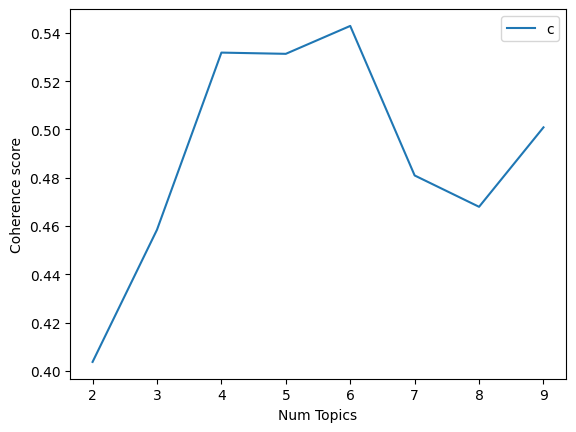

Num Topics = 2  has Coherence Value of 0.4037
Num Topics = 3  has Coherence Value of 0.4584
Num Topics = 4  has Coherence Value of 0.5318
Num Topics = 5  has Coherence Value of 0.5313
Num Topics = 6  has Coherence Value of 0.5429
Num Topics = 7  has Coherence Value of 0.4809
Num Topics = 8  has Coherence Value of 0.4679
Num Topics = 9  has Coherence Value of 0.5009


In [20]:
# Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

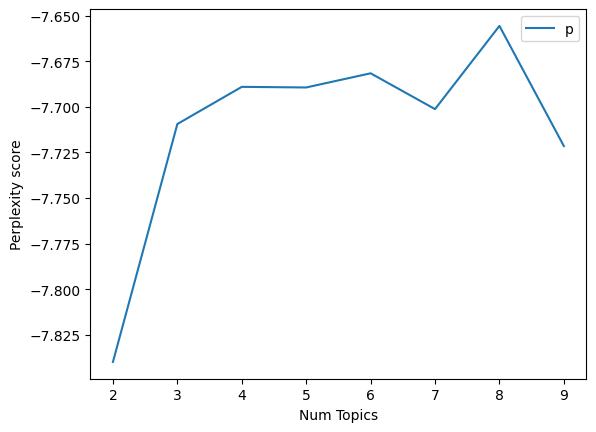

Num Topics = 2  has Perplexity Value of -7.8399
Num Topics = 3  has Perplexity Value of -7.7095
Num Topics = 4  has Perplexity Value of -7.6891
Num Topics = 5  has Perplexity Value of -7.6894
Num Topics = 6  has Perplexity Value of -7.6817
Num Topics = 7  has Perplexity Value of -7.7013
Num Topics = 8  has Perplexity Value of -7.6557
Num Topics = 9  has Perplexity Value of -7.7215


In [21]:
# Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, perplexity_list)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

# Print the perplexity scores
for m, cv in zip(x, perplexity_list):
    print("Num Topics =", m, " has Perplexity Value of", round(cv, 4))

In [32]:
best_num = 4

# Select the model and print the topics
optimal_model = model_list[best_num-2]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(0,
  '0.019*"music" + 0.015*"game" + 0.014*"mobil" + 0.014*"technolog" + 0.014*"peopl" + 0.011*"digit" + 0.010*"player" + 0.010*"tv" + 0.009*"video" + 0.009*"phone"'),
 (1,
  '0.018*"peopl" + 0.013*"user" + 0.012*"servic" + 0.011*"net" + 0.011*"phone" + 0.010*"softwar" + 0.010*"network" + 0.009*"system" + 0.009*"firm" + 0.009*"technolog"'),
 (2,
  '0.021*"game" + 0.012*"good" + 0.009*"time" + 0.009*"film" + 0.007*"player" + 0.007*"last" + 0.007*"world" + 0.007*"year" + 0.006*"first" + 0.005*"award"'),
 (3,
  '0.010*"govern" + 0.007*"peopl" + 0.006*"elect" + 0.006*"compani" + 0.005*"labour" + 0.005*"plan" + 0.005*"public" + 0.005*"market" + 0.005*"last" + 0.004*"countri"')]

In [33]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

C:\Users\User\anaconda3\envs\newtensorflow\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.052940  0.156946       1        1  44.588093
2     -0.197917 -0.072299       2        1  29.911922
1      0.147826  0.060733       3        1  13.806651
0      0.103031 -0.145379       4        1  11.693334, topic_info=           Term         Freq        Total Category  logprob  loglift
837        game  1998.000000  1998.000000  Default  30.0000  30.0000
54        music   669.000000   669.000000  Default  29.0000  29.0000
516       peopl  1976.000000  1976.000000  Default  28.0000  28.0000
668   technolog   707.000000   707.000000  Default  27.0000  27.0000
749       mobil   626.000000   626.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
72         sale   138.998570   583.824930   Topic4  -5.3352   0.7110
88          way   139.562761   790.694482   Topic4  -5.3312   0.4118
1868     comput   126.870160   433.657751   Topic4  -5.4265   0.9171
81         time   143.495590  1397.966894   Topic4  -5.3034  -0.1303
14      compani   123.675266   963.693525   Topic4  -5.4520   0.0930

[302 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
736        1  0.220957  access
736        3  0.627984  access
736        4  0.151181  access
4386       2  0.970079   actor
4386       4  0.026798   actor
...      ...       ...     ...
12017      4  0.976340    xbox
381        1  0.415916    year
381        2  0.450425    year
381        3  0.052671    year
381        4  0.080822    year

[503 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 1])

### Model 2.1 Gensim model with TF-IDF (alternative approach)

In [24]:
tfidf = TfidfModel(corpus=corpus, id2word = id2word, normalize = False)
corpus_tfidf = tfidf[corpus]

for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 4.299410658325935),
 (1, 6.212699025132605),
 (2, 6.660158002103826),
 (3, 11.743324214595075),
 (4, 4.200726383466528),
 (5, 3.1712223891564446),
 (6, 10.119589620741122),
 (7, 11.119589620741124),
 (8, 2.069741071290561),
 (9, 4.312234698683518),
 (10, 9.119589620741122),
 (11, 4.852803080046221),
 (12, 3.8249688718494954),
 (13, 3.5196767785539946),
 (14, 2.1083623653178685),
 (15, 10.119589620741122),
 (16, 4.660158002103826),
 (17, 5.910136255112173),
 (18, 8.377704566356472),
 (19, 7.312234698683518),
 (20, 5.212699025132604),
 (21, 5.142309697241206),
 (22, 3.806706665456767),
 (23, 6.212699025132605),
 (24, 7.119589620741122),
 (25, 4.834187401878874),
 (26, 6.064253558981567),
 (27, 3.3058084295240855),
 (28, 3.6849613931043983),
 (29, 2.3713967711516624),
 (30, 6.364702118577654),
 (31, 5.910136255112173),
 (32, 13.559030335661985),
 (33, 3.939680530726188),
 (34, 8.79766152585376),
 (35, 5.212699025132604),
 (36, 4.744550189394198),
 (37, 3.8528030800462214),
 (38, 3.29

In [25]:
# LDA model
num_topics = 5

lda_model = gensim.models.LdaMulticore(corpus = corpus_tfidf, id2word = id2word, num_topics = num_topics, 
                                       chunksize = 1000,
                                       passes = 50,
                                       iterations = 50,
                                       per_word_topics = True
                                      )

In [26]:
# Print the most common words per topic
pprint(lda_model.print_topics())

[(0,
  '0.007*"music" + 0.004*"song" + 0.004*"band" + 0.004*"elect" + 0.004*"album" '
  '+ 0.004*"parti" + 0.003*"polic" + 0.003*"award" + 0.003*"labour" + '
  '0.003*"artist"'),
 (1,
  '0.005*"govern" + 0.005*"tax" + 0.005*"economi" + 0.004*"market" + '
  '0.004*"price" + 0.004*"econom" + 0.004*"growth" + 0.004*"rate" + '
  '0.004*"elect" + 0.004*"labour"'),
 (2,
  '0.007*"site" + 0.006*"softwar" + 0.006*"user" + 0.005*"email" + '
  '0.005*"search" + 0.005*"net" + 0.005*"comput" + 0.005*"viru" + 0.005*"blog" '
  '+ 0.004*"program"'),
 (3,
  '0.006*"club" + 0.006*"game" + 0.005*"player" + 0.004*"wale" + 0.004*"match" '
  '+ 0.004*"team" + 0.004*"side" + 0.004*"injuri" + 0.004*"season" + '
  '0.004*"final"'),
 (4,
  '0.011*"film" + 0.009*"mobil" + 0.007*"phone" + 0.007*"game" + '
  '0.006*"technolog" + 0.005*"tv" + 0.004*"digit" + 0.004*"music" + '
  '0.004*"video" + 0.004*"devic"')]


In [27]:
# Model results evaluation + model visualization html file

pyLDAvis.enable_notebook()
model_filepath = 'LDA_Model_' + str(num_topics)

LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus_tfidf, id2word)
with open(model_filepath, 'wb') as f:
  pickle.dump(LDAvis_prepared, f)
  
with open(model_filepath, 'rb') as f:
  LDAvis_prepared = pickle.load(f)
  
pyLDAvis.save_html(LDAvis_prepared, 'LDAvis_prepared_' + str(num_topics) + '.html')

LDAvis_prepared

C:\Users\User\anaconda3\envs\newtensorflow\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.069540  0.203861       1        1  27.393202
4      0.159038 -0.088043       2        1  20.589981
0     -0.009130  0.042027       3        1  18.400122
3     -0.205266 -0.146221       4        1  17.869717
2      0.124897 -0.011625       5        1  15.746978, topic_info=          Term         Freq        Total Category  logprob  loglift
26        film  3067.000000  3067.000000  Default  30.0000  30.0000
749      mobil  2402.000000  2402.000000  Default  29.0000  29.0000
799      phone  2339.000000  2339.000000  Default  28.0000  28.0000
54       music  2856.000000  2856.000000  Default  27.0000  27.0000
225       club  1474.000000  1474.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
29        firm   523.219250  2129.546052   Topic5  -5.9308   0.4449
74      servic   480.528743  2219.833956   Topic5  -6.0159   0.3182
135       mani   461.109179  1701.157994   Topic5  -6.0571   0.5431
668  technolog   449.013626  2123.180988   Topic5  -6.0837   0.2949
14     compani   415.025240  2151.347134   Topic5  -6.1624   0.2030

[404 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
4386       2  0.851657     actor
4386       3  0.069698     actor
4386       4  0.000955     actor
4386       5  0.077337     actor
216        1  0.996373  aircraft
...      ...       ...       ...
1601       5  0.994658  worldcom
6999       5  0.997478      worm
12017      2  0.997573      xbox
214        1  0.992404      yuko
214        4  0.005753      yuko

[959 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 1, 4, 3])

#### Things to try to improve LDA:
* Try changing hyperparameters of LDA algorithm
* Try reducing/increasing the number of POS tags
* Try different stemmers/lemmatizers
* Try removing/leaving digits or even more radical - remove words containing numbers
* Try with/without stemming
* Try different alpha/beta parameters of LDA
* Try removing words with len < 2 or 3
* To choose the right number of topics for LDA compare the goodness of fit for various

#### LDA Parameters
* chunksize - Increasing chunksize will speed up training, at least as long as the chunk of documents easily fit into memory.
* passes/iterations - It is important to set the number of “passes” and “iterations” high enough.
* 2 Dirichlet hyperparameters: alpha and beta (or sometimes eta) - try arranging those as follows list(np.arange(0.01, 1, 0.3))  and try different params from there.
* To test different combinations of hyperparameters use nested for loops.